# Station Clustering (Winter 2018)
This notebook uses K-means clustering with PCA to group stations into 3 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [50]:
###
subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [51]:
subs_df[subs_df['start station latitude']>41]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender


In [52]:
#Number of weekend days and weekday days for Jan - March 2018
num_WE = 25
num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [53]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [54]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WE_unique = np.unique(np.concatenate((weekend_subs_trips_df['start station id'].unique(),weekend_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WE_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WE_unique)


[428, 3250, 3485, 3672, 3428, 3214, 3481, 3267]


True

In [55]:
weekend_subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
116,1347,2018-01-06 11:12:20.973,2018-01-06 11:34:48.773,72,382,18783,Subscriber,1968,1,5,5,11,11,50,Weekend,"(72, 382)"
117,471,2018-01-06 11:43:53.488,2018-01-06 11:51:44.696,72,479,25288,Subscriber,1992,1,5,5,11,11,26,Weekend,"(72, 479)"
118,304,2018-01-06 17:15:05.323,2018-01-06 17:20:09.783,72,515,32352,Subscriber,1974,1,5,5,17,17,44,Weekend,"(72, 515)"
119,374,2018-01-07 12:42:24.651,2018-01-07 12:48:38.807,72,450,16988,Subscriber,1983,1,6,6,12,12,35,Weekend,"(72, 450)"
120,334,2018-01-07 13:48:19.772,2018-01-07 13:53:54.086,72,173,31484,Subscriber,1977,1,6,6,13,13,41,Weekend,"(72, 173)"


In [56]:
WE_puhour_groupby = weekend_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WE_puhour_df = WE_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WE_dohour_groupby = weekend_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WE_dohour_df = WE_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [57]:
WE_counts_df = pd.concat([WE_puhour_df,WE_dohour_df],axis=1).fillna(0)
WE_counts_df['total_pickups'] = WE_counts_df['NumPickups'].sum(axis=1)
WE_counts_df['total_dropoffs'] = WE_counts_df['NumDropoffs'].sum(axis=1)

In [58]:
for num in range(24):
    WE_counts_df['Activity',num] =  WE_counts_df['NumPickups',num] + WE_counts_df['NumDropoffs',num]
    WE_counts_df['Flux',num] =  WE_counts_df['NumPickups',num] - WE_counts_df['NumDropoffs',num]
WE_counts_df['total_counts'] = WE_counts_df['Activity'].sum(axis=1)

# Normalize by total activity for station -- maybe just do this right before clustering step?
for num in range(24):
    WE_counts_df['norm_Activity',num] =  WE_counts_df['Activity',num]/WE_counts_df['total_counts']
    WE_counts_df['norm_Flux',num] =  WE_counts_df['Flux',num]/WE_counts_df['total_counts']


In [59]:
WE_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                         \
pickup_hour         0     1     2     3     4    5     6     7      8      9    
435               21.0  20.0  14.0   3.0   4.0  3.0   3.0   9.0  144.0  195.0   
285               52.0  37.0  14.0   9.0   5.0  3.0  15.0  14.0   62.0   99.0   
497               36.0  30.0   7.0   7.0   6.0  4.0  11.0  20.0   46.0   91.0   
368               45.0  35.0  21.0  18.0  12.0  7.0  10.0  34.0   71.0  112.0   
459               19.0  18.0   1.0   2.0   1.0  1.0   0.0  13.0   30.0   70.0   

               ...    norm_Activity norm_Flux norm_Activity norm_Flux  \
pickup_hour    ...               19        19            20        20   
435            ...         0.049230  0.007140      0.035826 -0.002756   
285            ...         0.062420  0.005415      0.045746  0.000998   
497            ...         0.044614 -0.000144      0.031909  0.002743   
368            ...         0.049035 -0.003363      0.044433 -0.004072   
459            ...         0.055383  0.011150      0.040943  0.015719   

            norm_Activity norm_Flux norm_Activity norm_Flux norm_Activity  \
pickup_hour            21        21            22        22            23   
435              0.025930  0.004384      0.012276  0.003257      0.009645   
285              0.035485  0.002138      0.020379  0.003278      0.018669   
497              0.021946  0.006064      0.014005  0.004187      0.010396   
368              0.033103  0.001947      0.023367 -0.001062      0.018056   
459              0.023396  0.010236      0.015719  0.006215      0.008956   

            norm_Flux  
pickup_hour        23  
435          0.002380  
285          0.004703  
497          0.004332  
368          0.002832  
459          0.006397  

[5 rows x 147 columns]

In [60]:
print(len(WE_counts_df))
len(stations_info_df)

769


769

In [61]:
for el in WE_counts_df.index:
    if el not in stations_info_df.index:
        print(el)
        

In [62]:
#Imported/modified from UMICH coursera course, a simple scatter plot function

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    #plt.zlim(z_min, z_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    

In [63]:
import tilemapbase
tilemapbase.start_logging()

In [64]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [65]:
t = tilemapbase.tiles.Carto_Light

In [66]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

In [67]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'

# Clustering with Activity and norm_Flux

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WE_counts_df[['norm_Activity','norm_Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(769, 48) (769, 2)


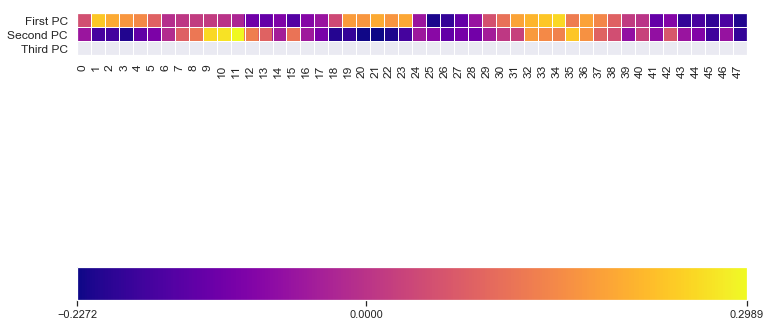

In [80]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

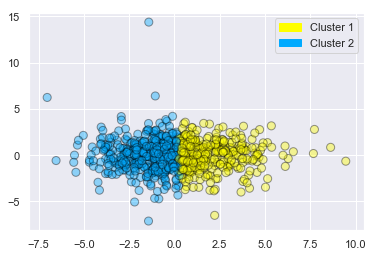

In [82]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_pca)

WE_counts_df['KNN_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2'])

Plotting norm_Flux

In [83]:
test_df=WE_counts_df[['norm_Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [84]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

In [85]:
test_melt_df.head()

,hour,station,count,KNN_label
0,0,72,-0.005553,1
1,1,72,0.001010,1
2,2,72,-0.001010,1
3,3,72,0.004038,1
4,4,72,0.002524,1


C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


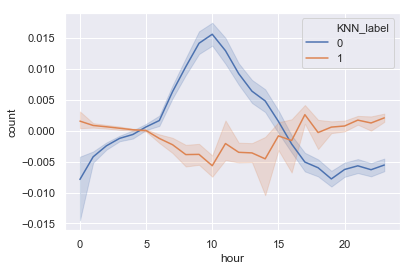

In [86]:
## Using norm_Flux 
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=2), data=test_melt_df)

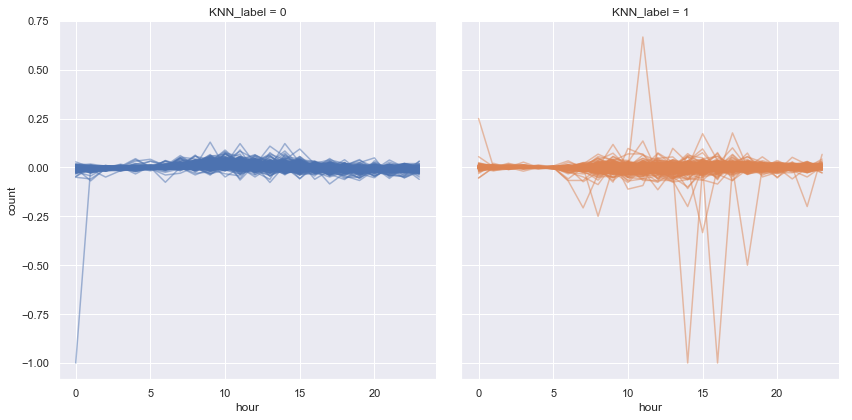

In [87]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

Plotting Activity

In [88]:
test_df=WE_counts_df[['norm_Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [89]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

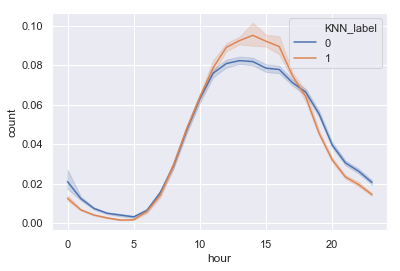

In [90]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=2), data=test_melt_df)


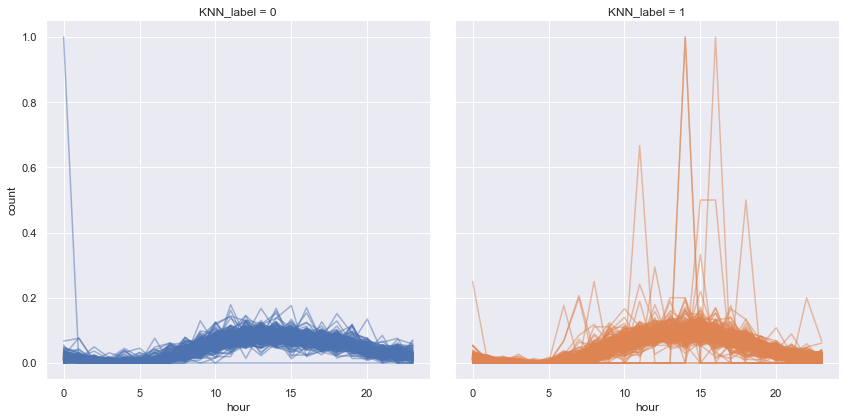

In [91]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [92]:
stations_info_df['KNN_label'] = WE_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

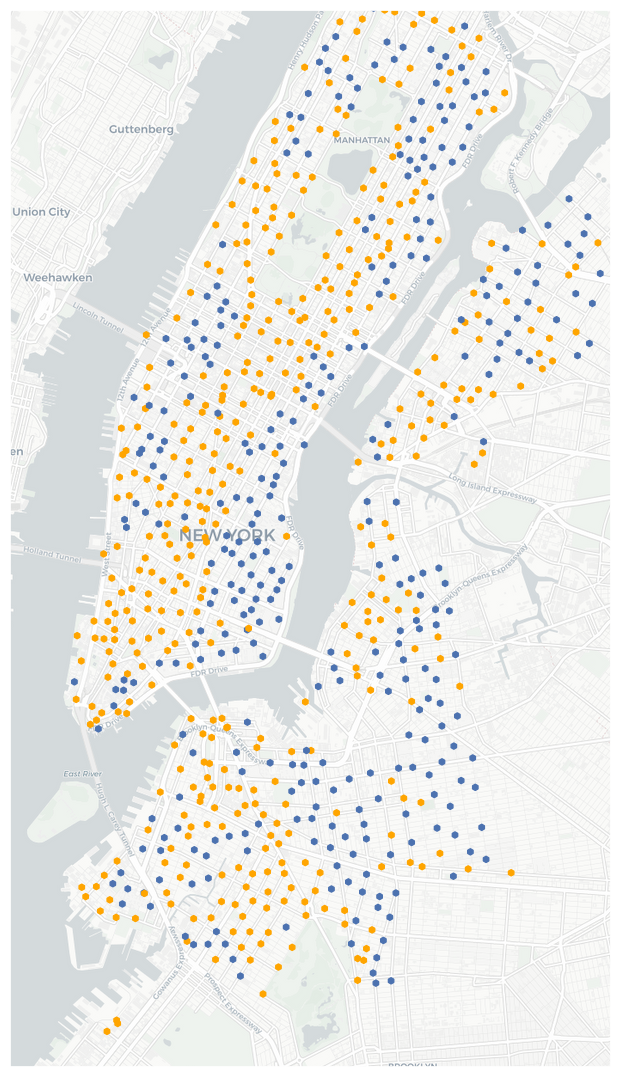

In [93]:
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

## Now using Activity and Flux

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WE_counts_df[['Activity','Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(769, 48) (769, 2)


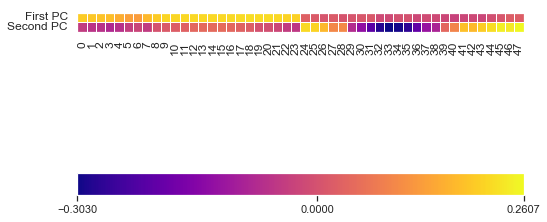

In [98]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

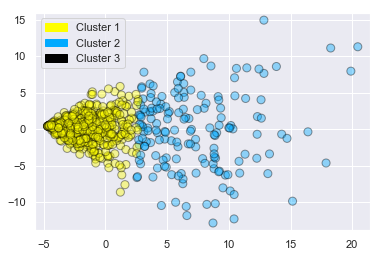

In [99]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])
#plot_labelled_scatter(X_pca, kmeans.labels_, 
#                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
#plot_labelled_scatter(X_pca, kmeans.labels_, 
#                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

In [101]:
WE_counts_df['KNN_label'] = kmeans.labels_

Plotting Flux

In [102]:
test_df=WE_counts_df[['Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [103]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


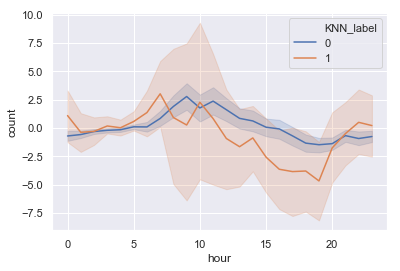

In [104]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


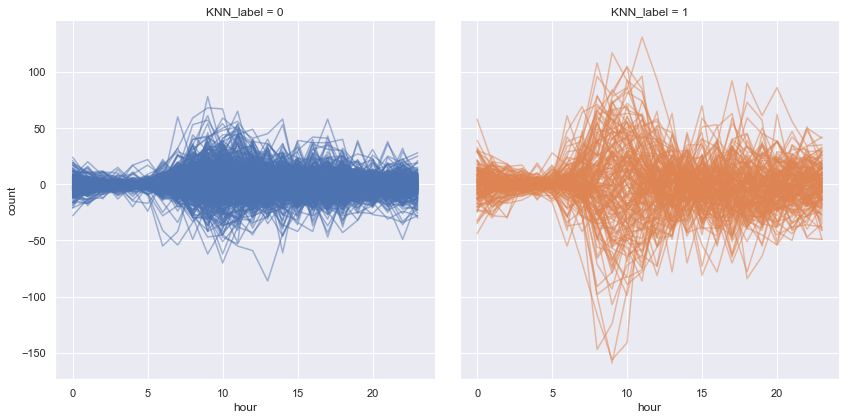

In [105]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

Plotting Activity

In [106]:
test_df=WE_counts_df[['Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [107]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

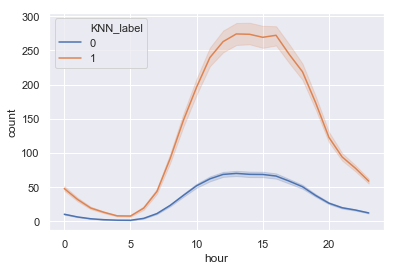

In [108]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


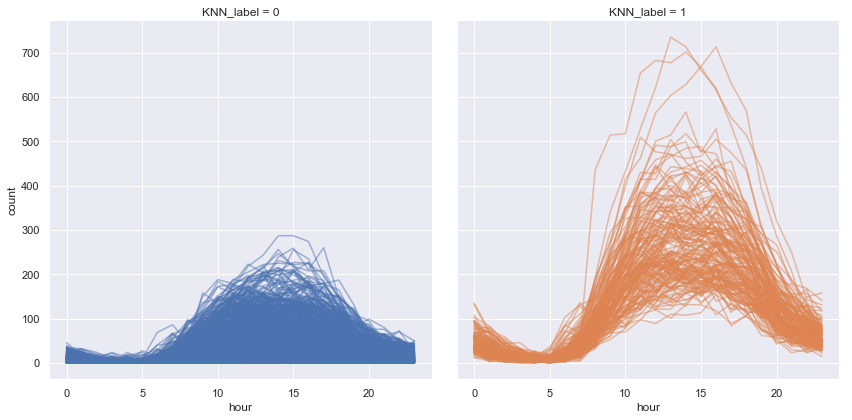

In [109]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [110]:
stations_info_df['KNN_label'] = WE_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

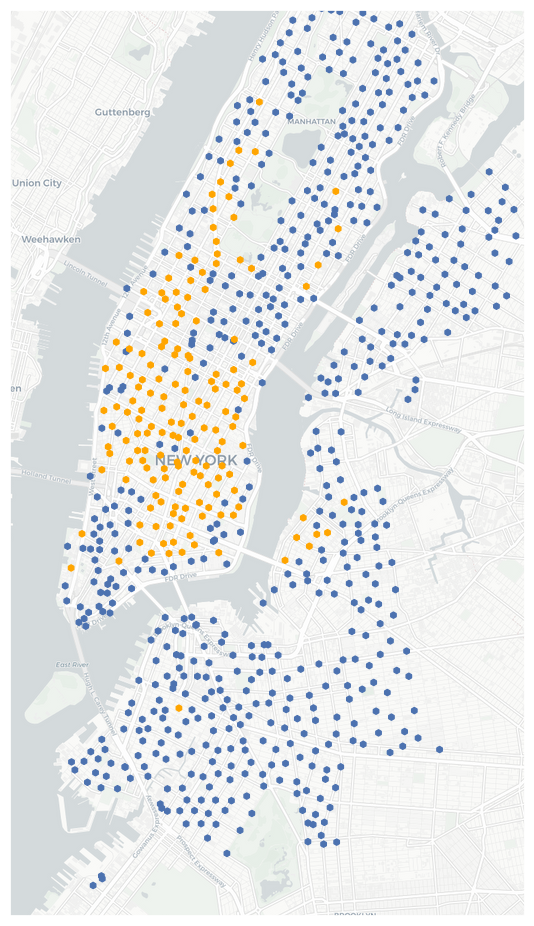

In [111]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
   
#plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
#
#ax.set_title('Winter 2018, weekday dropoffs, hour = {}'.format(num))

#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
#cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WE_max_dropoff_cap/2/num_WE) , '> ' +  '{:.1f} per day'.format(WE_max_dropoff_cap/num_WE)])# vertically oriented colorbar

#plt.savefig('./Images/Winter_2018/Winter_2018_WE_drops_{}.png'.format(str(num)));
#plt.close()